### In this tutorial we are going to build a regression model using Pytorch

#### Regression

A regression is a statistical technique that relates a dependent variable to one or more independent (explanatory) variables.A regression model is able to show whether changes observed in the dependent variable are associated with changes in one or more of the explanatory variable

In [3]:
import torch
import matplotlib.pyplot as plt

# 1) Data Preparation

In [4]:
# Lets create some data for regression
w = 0.6 # Refers to weight or you can say slope
b = 0.2 # Refers to bias or intercept 

start = 1
end =3

step = 0.04
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = w*X + b

X[:10], y[:10]

(tensor([[1.0000],
         [1.0400],
         [1.0800],
         [1.1200],
         [1.1600],
         [1.2000],
         [1.2400],
         [1.2800],
         [1.3200],
         [1.3600]]),
 tensor([[0.8000],
         [0.8240],
         [0.8480],
         [0.8720],
         [0.8960],
         [0.9200],
         [0.9440],
         [0.9680],
         [0.9920],
         [1.0160]]))

In [6]:
# Check shape
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [7]:
# Split Data into training and testing set

split = int(0.7*len(X))

X_train, y_train = X[:split],y[:split]
X_test, y_test = X[split:], y[split:]

len(X_train)

35

In [16]:
# Create a helping function to plot line

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
   
    plt.figure(figsize=(12, 8))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=8, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=8, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=8, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

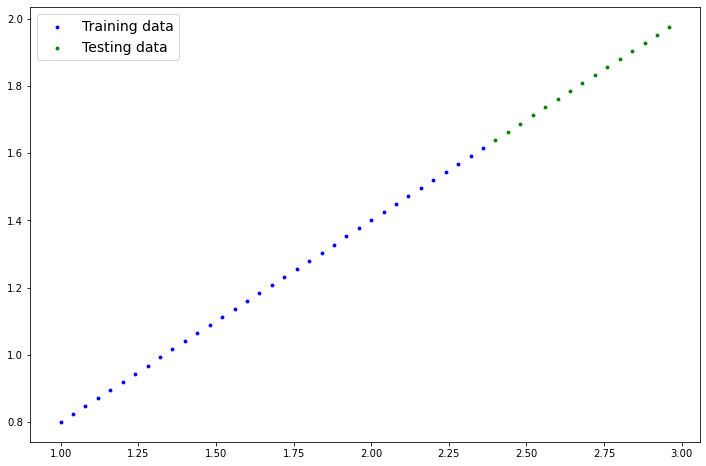

In [15]:
plot_predictions()

# 2) Build Model

In [24]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.weights = torch.nn.Parameter(torch.randn(1,dtype=torch.float))
        self.bias = torch.nn.Parameter(torch.randn(1,dtype=torch.float))
        
    #Forward propagation function
    
    def forward(self,x:torch.Tensor) ->torch.Tensor:
        return self.weights * x + self.bias

###  PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network.


They are torch.nn, torch.optim, torch.utils.data.Dataset and torch.utils.data.DataLoader


#### torch.nn: 

Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way)

#### torch.nn.Parameter: 

Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

#### torch.nn.Module: 

The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

#### torch.optim:

Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

#### def forward():

All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).


### Checking the Model

In [25]:
model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([1.4559], requires_grad=True),
 Parameter containing:
 tensor([0.6530], requires_grad=True)]

In [26]:
# List names of parameters

model_0.state_dict()

OrderedDict([('weights', tensor([1.4559])), ('bias', tensor([0.6530]))])

### Make prediction using torch.inference_model()


In [32]:
with torch.no_grad(): 
    y_pred = model_0(X_test)

In [33]:
y_pred[:10]

tensor([[4.1472],
        [4.2054],
        [4.2636],
        [4.3219],
        [4.3801],
        [4.4383],
        [4.4966],
        [4.5548],
        [4.6130],
        [4.6713]])

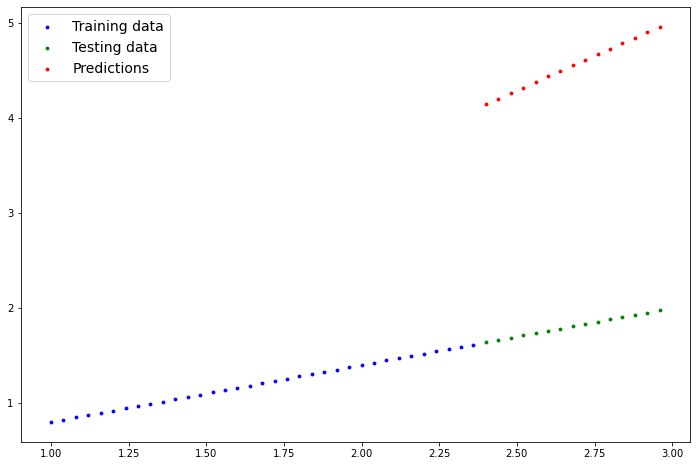

In [34]:
# Lets check the predictions

plot_predictions(predictions=y_pred)

In [35]:
# Calculate the MSE for the model

sum((y_test - y_pred)**2)/len(y_test)

tensor([7.5668])

In [36]:
# SSE
sum((y_test - y_pred)**2)

tensor([113.5027])

# Train Model

### For building the model we have to specify a training loop

### Steps of Training Loop

#### 1) Forward Pass 

The model goes through all of the training data once, performing its forward() function calculations.

#### 2) Calculate the loss

The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.

#### 3)  Zero gradients

The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.

#### 4) Perform backpropagation on the loss

Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards".

#### 5) Update the optimizer (gradient descent)

Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.


### Steps for Testing Model

#### 1) Forward Pass 

The model goes through all of the training data once, performing its forward() function calculations.

#### 2) Calculate the loss

The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.

#### 3) Calculate evaluation metrics

Alongisde the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.

In [51]:
# Create Model instance
model_0 = LinearRegression()

# Create the loss function
loss_fn = torch.nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01)

In [56]:
# Set the number of epochs 
epochs = 300

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss 
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.no_grad():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.06856981664896011 | MAE Test Loss: 0.1688982993364334 
Epoch: 10 | MAE Train Loss: 0.06549524515867233 | MAE Test Loss: 0.15894612669944763 
Epoch: 20 | MAE Train Loss: 0.06244484335184097 | MAE Test Loss: 0.1523219794034958 
Epoch: 30 | MAE Train Loss: 0.059394415467977524 | MAE Test Loss: 0.14569781720638275 
Epoch: 40 | MAE Train Loss: 0.05634397268295288 | MAE Test Loss: 0.13907399773597717 
Epoch: 50 | MAE Train Loss: 0.05326934531331062 | MAE Test Loss: 0.12912212312221527 
Epoch: 60 | MAE Train Loss: 0.05021890997886658 | MAE Test Loss: 0.12249818444252014 
Epoch: 70 | MAE Train Loss: 0.04716844484210014 | MAE Test Loss: 0.11587435752153397 
Epoch: 80 | MAE Train Loss: 0.04411647841334343 | MAE Test Loss: 0.10925041139125824 
Epoch: 90 | MAE Train Loss: 0.041043370962142944 | MAE Test Loss: 0.09929852932691574 
Epoch: 100 | MAE Train Loss: 0.0379929356276989 | MAE Test Loss: 0.09267466515302658 
Epoch: 110 | MAE Train Loss: 0.034942496567964554 | MAE

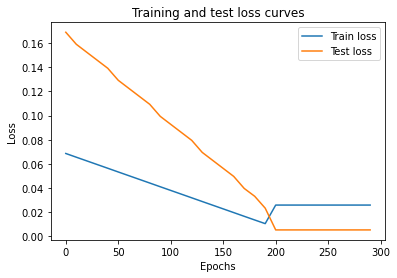

In [57]:
# Plot loss curves

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# 4) Make Predictions

### Some important things you have to remember before predictions

1) Set model into evaluation mode model.eval()

2) Make a context manager

3) All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [58]:
model_0.eval()

with torch.no_grad():
    y_pred = model_0(X_test)

y_pred[:10]

tensor([[1.5893],
        [1.6119],
        [1.6345],
        [1.6572],
        [1.6798],
        [1.7024],
        [1.7250],
        [1.7477],
        [1.7703],
        [1.7929]])

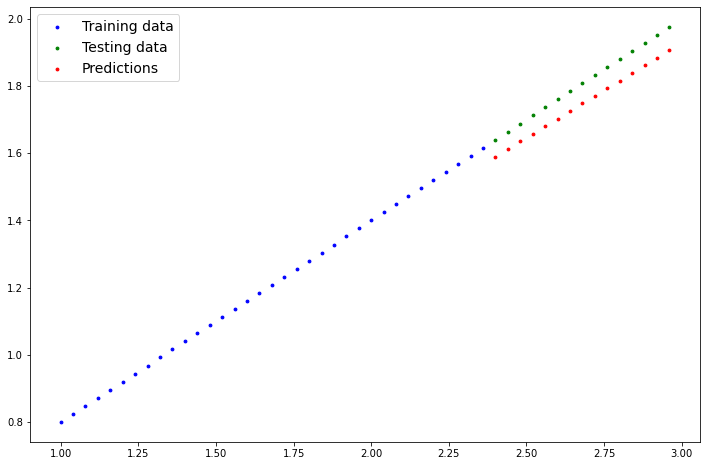

In [60]:
plot_predictions(predictions=y_pred)

### Now here we can see that our model immproved

# Build Model using torch.nn.Linear Module

In [71]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_layer = torch.nn.Linear(in_features=1,out_features=1)
        
        
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.linear_layer(x)

In [72]:
# create model instance

model_1 = LinearRegressionModel()

In [73]:
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.5561]])),
              ('linear_layer.bias', tensor([-0.5981]))]))

In [74]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [75]:
# Create loss function
loss_fn = torch.nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [78]:
epochs = 2000 


for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.no_grad():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.7953166961669922 | Test loss: 0.7505436539649963
Epoch: 200 | Train loss: 0.060624606907367706 | Test loss: 0.14902406930923462
Epoch: 400 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 600 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 800 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 1000 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 1200 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 1400 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 1600 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885
Epoch: 1800 | Train loss: 0.024430332705378532 | Test loss: 0.004088695626705885


In [79]:
### Make Predictions

# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.no_grad():
    y_pred = model_1(X_test)
y_pred

tensor([[1.6893],
        [1.7146],
        [1.7400],
        [1.7654],
        [1.7908],
        [1.8162],
        [1.8415],
        [1.8669],
        [1.8923],
        [1.9177],
        [1.9431],
        [1.9684],
        [1.9938],
        [2.0192],
        [2.0446]])

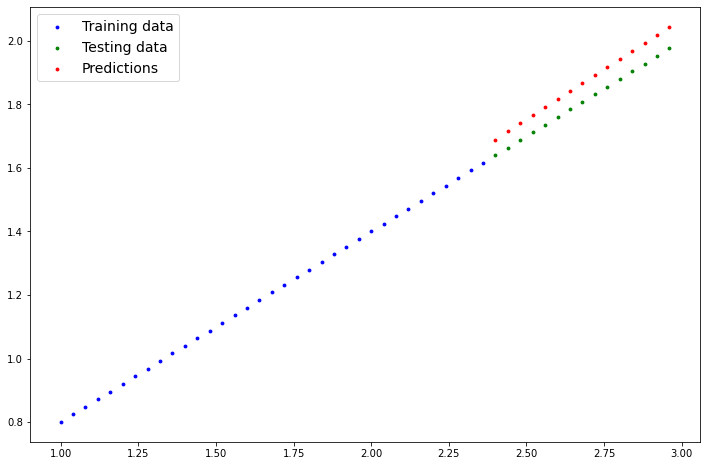

In [80]:
plot_predictions(predictions=y_pred)

# Save the Model

In [83]:
import os

# create model directory

model_path = 'models'
os.mkdir(model_path)

# Create model save path

model_name = 'lesson_01_model.pth'
model_path_save = os.path.join(model_path,model_name)

# Save the model

torch.save(obj=model_1.state_dict(),f=model_path_save)

## Reload Model for predictions

In [85]:
# Create a dataset

start = 3
end = 4
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = w*X + b

X[:10], y[:10]

(tensor([[3.0000],
         [3.0400],
         [3.0800],
         [3.1200],
         [3.1600],
         [3.2000],
         [3.2400],
         [3.2800],
         [3.3200],
         [3.3600]]),
 tensor([[4.8000],
         [4.8240],
         [4.8480],
         [4.8720],
         [4.8960],
         [4.9200],
         [4.9440],
         [4.9680],
         [4.9920],
         [5.0160]]))

In [87]:
loaded_model = LinearRegressionModel()

# load model stats
loaded_model.load_state_dict(torch.load(model_path_save))

loaded_model,loaded_model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.6345]])),
              ('linear_layer.bias', tensor([0.1665]))]))

In [90]:
# Predictions
loaded_model.eval()

with torch.no_grad():
    preds = loaded_model(X)
    

    
# Calulate loss

# Create loss function
loss_fn = torch.nn.L1Loss()
loss_fn(preds,y)

tensor(2.7135)

# THE END